In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
import sklearn as sk
import datetime as dt

import warnings

warnings.filterwarnings('ignore')

In [114]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import scale
import xgboost
from sklearn.preprocessing import StandardScaler

In [3]:
# 테이블 현황 파악을 위한 함수 
def summary_table(table):
    df = pd.DataFrame()
    for i in table.columns:
        name = i
        dtype = table[i].dtype.name
        null = table[i].isnull().sum()
        act = table.shape[0] - null
        unique = len(table[i].unique())
        data = {'name': name, 'dtype': dtype, 'null': null, 'act': act, 'unique': unique}
        df = df.append(data, ignore_index=True)
    return df

### 데이터 불러오기: 일본어는 영어로 번역, 지역에 Prefecture가 붙은 지명은 Prefecture 제외

In [5]:
# train 
detail_train = pd.read_csv('coupon_data_project2/coupon_detail_train_translated_en.csv', parse_dates=['I_DATE'])
visit_train = pd.read_csv('coupon_data_project2/coupon_visit_train.csv', parse_dates=['I_DATE'])

area_train = pd.read_csv('coupon_data_project2/coupon_area_train_translated_en.csv')
coupon_list_train = pd.read_csv('coupon_data_project2/coupon_list_train_translated_en.csv', parse_dates=['DISPFROM', 'DISPEND', 'VALIDFROM', 'VALIDEND'])

# base data
# location = pd.read_csv('coupon_data_project2/train_location2.csv')
# area_test = pd.read_csv('coupon_data_project2/test_location2.csv')
user_list = pd.read_csv('coupon_data_project2/user_list_translated_en.csv', parse_dates=['WITHDRAW_DATE', 'REG_DATE'])

# test data
# area_test = pd.read_csv('coupon_data_project2/coupon_area_test_translated_en.csv')
coupon_list_test = pd.read_csv('coupon_data_project2/coupon_list_test_translated_en.csv', parse_dates=['DISPFROM', 'DISPEND', 'VALIDFROM', 'VALIDEND'])

# submisiion
submission = pd.read_csv('coupon_data_project2/sample_submission.csv')

In [187]:
proba_location = pd.read_csv('coupon_data_project2/proba_location.csv')
proba_genre = pd.read_csv('coupon_data_project2/proba_genre.csv')
proba_case = pd.read_csv('coupon_data_project2/proba_case.csv')

In [370]:
visit_proba_location = pd.read_csv('coupon_data_project2/visit_proba_location.csv')
visit_proba_genre = pd.read_csv('coupon_data_project2/visit_proba_genre.csv')
visit_proba_case = pd.read_csv('coupon_data_project2/visit_proba_case.csv')

## A. Preprocessing

### A-1. detail_train

#### 1) 신규 columns 생성

1-1) merge 후 구매 구분을 위한 PURCHASE_FLG

In [6]:
detail_train['PURCHASE_FLG'] = 1

#### 2) column명 변경

2-1) I_DATE -> purchase_date: 구매 일자 구분

2-2) SMALL_AREA_NAME: coupon list의 지역(판매 spot)과 구분하기 위함

In [7]:
detail_train.rename(columns = {'I_DATE': 'purchase_date'}, inplace=True)
detail_train.rename(columns = {'SMALL_AREA_NAME': 'resid_small'}, inplace=True)

#### 3) drop: ITEM_COUNT는 활요여부 판단후 처리

In [7]:
# detail_train.drop(labels = ['ITEM_COUNT'], axis=1, inplace=True)
# detail_train.drop(labels = ['PURCHASEID_hash'], axis=1, inplace=True)
# detail_train.drop(labels = ['resid_small'], axis=1, inplace=True)
# detail_train.drop(labels = ['purchase_date'], axis=1, inplace=True)

### A-2. visit_train

#### 1) 신규 column 생성

In [8]:
visit_train['VIEW'] = 1

#### 2) column명 변경

In [9]:
visit_train.rename(columns = {'I_DATE': 'VIEW_DATE'}, inplace=True)
visit_train.rename(columns = {'VIEW_COUPON_ID_hash': 'COUPON_ID_hash'}, inplace=True)

#### 3) drop

In [10]:
visit_train.drop(labels = ['PAGE_SERIAL'], axis=1, inplace=True)
visit_train.drop(labels = ['REFERRER_hash'], axis=1, inplace=True)
visit_train.drop(labels = ['SESSION_ID_hash'], axis=1, inplace=True)
visit_train.drop(labels = ['PURCHASEID_hash'], axis=1, inplace=True)

In [11]:
visit_train[:2]

,PURCHASE_FLG,VIEW_DATE,COUPON_ID_hash,USER_ID_hash,VIEW
0,0,2012-03-28 14:15:00,34c48f84026e08355dc3bd19b427f09a,d9dca3cb44bab12ba313eaa681f663eb,1
1,0,2012-03-28 14:17:28,34c48f84026e08355dc3bd19b427f09a,d9dca3cb44bab12ba313eaa681f663eb,1


### A-3. Coupon_list

#### 1) 전처리 일관성을 유지를 위한 coupon_list merge(311~ train임)

In [12]:
coupon_list = pd.merge(coupon_list_test, coupon_list_train, how='outer')

In [13]:
coupon_list_test.shape, coupon_list_train.shape, coupon_list.shape

((310, 24), (19413, 24), (19723, 24))

#### 2) 신규 columns 생성

In [14]:
# 캡슐과 장르 통합 및 명칭 변경
coupon_list['Case'] = coupon_list['CAPSULE_TEXT'] + coupon_list['GENRE_NAME']
coupon_list['Case'] = coupon_list['Case'].apply(lambda x: "HOTEL" if x == 'Guest houseHotel and Japanese hotel' 
                          or x == 'HotelHotel and Japanese hotel'
                          or x == 'Japanese hotelHotel and Japanese hotel'
                          or x == 'Japanse guest houseHotel and Japanese hotel'
                          or x == 'LodgeHotel and Japanese hotel'
                          or x == 'Public hotelHotel and Japanese hotel'
                          or x == 'Resort innHotel and Japanese hotel'
                          or x == 'Vacation rentalHotel and Japanese hotel'
                          else "NAIL" if x == 'Nail and eye salonNail and eye salon'
                          else "HAIR" if x == 'Hair salonHair salon'
                          else "FOOD" if x == 'FoodFood'
                          else "SPA" if x == 'SpaSpa'
                          else "BEAUTY" if x == 'BeautyBeauty'
                          else "CLASS" if x == 'ClassLesson'
                          else "CORRESPONDENCE" if x == 'Correspondence courseLessonClassLesson'
                          else "DELIVERY" if x == 'Delivery serviceDelivery service'
                          else "EVENT" if x == 'EventOther coupon'
                          else "GIFT" if x == 'Gift cardGift card'
                          else "HEALTH" if x == 'Health and medicalHealth and medical'
                          else "LEISURE" if x == 'LeisureLeisure'
                          else "LESSON" if x == 'LessonLesson'
                          else "OTHER" if x == 'OtherOther coupon'
                          else "RELAXATION" if x == 'RelaxationRelaxation'
                          else "WEB" if x == 'Web serviceOther coupon'
                          else 'OTHER'
                          )

In [15]:
# 실판매가 게산
coupon_list['Price'] = coupon_list['CATALOG_PRICE'] - coupon_list['DISCOUNT_PRICE']

In [16]:
# 실판매가 정규화
coupon_list["lnDPRICE"] = np.log1p(coupon_list["Price"])
coupon_list["mDPRICE"] = coupon_list.groupby("Case")["lnDPRICE"].transform(np.mean)
coupon_list["sDPRICE"] = coupon_list.groupby("Case")["lnDPRICE"].transform(np.std)
coupon_list["zprice"] = (coupon_list["lnDPRICE"] - coupon_list["mDPRICE"]) / coupon_list["sDPRICE"]

#### 3) column명 변경

In [17]:
# 지역명 변경
coupon_list.rename(columns = {"LARGE_AREA_NAME": "spot_large", 
                              "ken_name": "spot_pref", 
                              "SMALL_AREA_NAME": "spot_small"}, inplace=True)

#### 4) Null 값 및 오류 처리

In [18]:
# usable: nan -> 1, 2 -> 0
coupon_list['USABLE_DATE_MON'].replace([0,2,1,np.nan],[0,0,1,1], inplace=True)
coupon_list['USABLE_DATE_TUE'].replace([0,2,1,np.nan],[0,0,1,1], inplace=True)
coupon_list['USABLE_DATE_WED'].replace([0,2,1,np.nan],[0,0,1,1], inplace=True)
coupon_list['USABLE_DATE_THU'].replace([0,2,1,np.nan],[0,0,1,1], inplace=True)
coupon_list['USABLE_DATE_FRI'].replace([0,2,1,np.nan],[0,0,1,1], inplace=True)
coupon_list['USABLE_DATE_SAT'].replace([0,2,1,np.nan],[0,0,1,1], inplace=True)
coupon_list['USABLE_DATE_SUN'].replace([0,2,1,np.nan],[0,0,1,1], inplace=True)
coupon_list['USABLE_DATE_HOLIDAY'].replace([0,2,1,np.nan],[0,0,1,1], inplace=True)
coupon_list['USABLE_DATE_BEFORE_HOLIDAY'].replace([0,2,1,np.nan],[0,0,1,1], inplace=True)

#### 5) drop

In [19]:
# coupon_list.drop(labels = ['CAPSULE_TEXT'], axis=1, inplace=True )
# coupon_list.drop(labels = ['GENRE_NAME'], axis=1, inplace=True )
# coupon_list.drop(labels = ['CATALOG_PRICE'], axis=1, inplace=True )
# coupon_list.drop(labels = ['DISCOUNT_PRICE'], axis=1, inplace=True )
# coupon_list.drop(labels = ['DISPFROM'], axis=1, inplace=True )
# coupon_list.drop(labels = ['DISPEND'], axis=1, inplace=True )
# coupon_list.drop(labels = ['VALIDFROM'], axis=1, inplace=True )
# coupon_list.drop(labels = ['VALIDEND'], axis=1, inplace=True )
# coupon_list.drop(labels = ['lnDPRICE'], axis=1, inplace=True )
# coupon_list.drop(labels = ['mDPRICE'], axis=1, inplace=True )
# coupon_list.drop(labels = ['sDPRICE'], axis=1, inplace=True )



#### 6) train & test set 분리

In [20]:
# train set과 test set을 다시 분리
coupon_list_train = coupon_list[311:]
coupon_list_test = coupon_list[:310]

### A4. User_list

#### 1) column명 변경

In [21]:
user_list.rename(columns = {'PREF_NAME': 'user_pref'}, inplace=True)

#### 2) SEX_ID 0,1 로 변경(f: 0, m: 1)

In [22]:
# SEX_ID: f는 0으로 M은 1로
user_list['SEX_ID'] = user_list['SEX_ID'].apply(lambda x: 0 if x == 'f' else 1) 

#### 3) drop

In [23]:
# REG_DATE , WITHDRAW_DATE 삭제
user_list.drop(labels = ['REG_DATE'], axis=1, inplace=True)
user_list.drop(labels = ['WITHDRAW_DATE'], axis=1, inplace=True)


In [24]:
user_list[:2]

,SEX_ID,AGE,user_pref,USER_ID_hash
0,0,25,NaN,d9dca3cb44bab12ba313eaa681f663eb
1,0,34,Tokyo,560574a339f1b25e57b0221e486907ed


### A5. train set 구성

#### 1) visit_train & detail_train -> train

In [25]:
train= pd.merge(visit_train, detail_train, how='outer')

In [26]:
train.shape

(2913043, 9)

#### 2) train & coupon_list

In [27]:
train = pd.merge(train, coupon_list, how='left', on='COUPON_ID_hash')

In [28]:
train.shape # 315,029 개의 sell은 기초정보에 존재 하지 않던 쿠폰리스트임

(2913043, 38)

#### 3) train & user_list

In [29]:
train = pd.merge(train, user_list, how='left', on='USER_ID_hash')

In [30]:
train.shape

(2913043, 41)

#### 4) train & location

In [103]:
train['key'] = train['COUPON_ID_hash']+ train['USER_ID_hash']

In [104]:
location['key'] = location['COUPON_ID_hash'] + location['USER_ID_hash'] 
location.drop_duplicates(['key'], inplace=True)

In [107]:
train.drop(['distance', 'PREF_in'],1, inplace=True)

In [108]:
train.insert(2, 'distance', train['key'].map(location.set_index('key')['distance']))
train.insert(2, 'PREF_in', train['key'].map(location.set_index('key')['PREF_in']))

In [109]:
train.drop(labels=['key'], axis=1, inplace=True)

In [118]:
user_list.user_pref.isnull().sum()

7256

#### 4) train 현황 점검 및 NaN값 처리

4-1) null 이 315,301개인 것들은 기초정보(coupon_list(test 포함)에 없는 것들이므로 제외 -> zprice 기준으로 처리

4-2) VALIDPERIOD(null: 773,492)은 무제한이라는 의미에서 10,000으로 처리

4-3) user_pref(null: 488,972) 을 NN 으로 처리

In [31]:
# null 이 315,301개인 것들은 기초정보(coupon_list(test 포함)에 없는 것들이므로 제외 -> zprice 기준으로 처리
train = train[train['Price'] >= 0]

In [32]:
train['VALIDPERIOD'] = train['VALIDPERIOD'].fillna(180)
# train['user_pref'] = train['user_pref'].fillna('NN')
train['VIEW'] = train['VIEW'].fillna(0)

In [119]:
train['distance'] = train['distance'].fillna(train['distance'].mean())

In [37]:
summary_table(train).sort_values(by='unique', ascending = True)

,act,dtype,name,null,unique
0,2597810.0,int64,PURCHASE_FLG,0.0,2.0
24,2597810.0,float64,USABLE_DATE_WED,0.0,2.0
25,2597810.0,float64,USABLE_DATE_THU,0.0,2.0
26,2597810.0,float64,USABLE_DATE_FRI,0.0,2.0
27,2597810.0,float64,USABLE_DATE_SAT,0.0,2.0
28,2597810.0,float64,USABLE_DATE_SUN,0.0,2.0
23,2597810.0,float64,USABLE_DATE_TUE,0.0,2.0
30,2597810.0,float64,USABLE_DATE_BEFORE_HOLIDAY,0.0,2.0
29,2597810.0,float64,USABLE_DATE_HOLIDAY,0.0,2.0
6,2597810.0,float64,VIEW,0.0,2.0


In [33]:
train['VALIDPERIOD'].max()

180.0

In [39]:
# train['usable_week'] = train['USABLE_DATE_MON'] + train['USABLE_DATE_WED'] + train['USABLE_DATE_THU'] + train['USABLE_DATE_FRI'] + train['USABLE_DATE_SAT'] + train['USABLE_DATE_SUN'] + train['USABLE_DATE_TUE'] + train['USABLE_DATE_BEFORE_HOLIDAY'] + train['USABLE_DATE_HOLIDAY']

In [34]:
train["VALID"] = train["VIEW_DATE"] - train["DISPFROM"]
train["VALID"] = train["VALID"].astype('timedelta64[s]') /60
# train3["VALID"] = train3['VALID'].apply(lambda x: x.total_seconds() / 60 )
# train3['VALID'] = train3['VALID'].fillna(5000)

In [35]:
train['VALID'] = train['VALID'].fillna(train['VALID'][train['PURCHASE_FLG']==1].mean())

In [36]:
train.columns

Index(['PURCHASE_FLG', 'VIEW_DATE', 'COUPON_ID_hash', 'USER_ID_hash', 'VIEW',
       'ITEM_COUNT', 'purchase_date', 'resid_small', 'PURCHASEID_hash',
       'CAPSULE_TEXT', 'GENRE_NAME', 'PRICE_RATE', 'CATALOG_PRICE',
       'DISCOUNT_PRICE', 'DISPFROM', 'DISPEND', 'DISPPERIOD', 'VALIDFROM',
       'VALIDEND', 'VALIDPERIOD', 'USABLE_DATE_MON', 'USABLE_DATE_TUE',
       'USABLE_DATE_WED', 'USABLE_DATE_THU', 'USABLE_DATE_FRI',
       'USABLE_DATE_SAT', 'USABLE_DATE_SUN', 'USABLE_DATE_HOLIDAY',
       'USABLE_DATE_BEFORE_HOLIDAY', 'spot_large', 'spot_pref', 'spot_small',
       'Case', 'Price', 'lnDPRICE', 'mDPRICE', 'sDPRICE', 'zprice', 'SEX_ID',
       'AGE', 'user_pref', 'VALID'],
      dtype='object')

### train에 proba 추가

In [71]:
proba_case.columns , proba_genre.columns, proba_location.columns

(Index(['Case', '총개수', '구매수', 'proba_case'], dtype='object'),
 Index(['GENRE_NAME', '총개수', '구매수', 'proba_GENRE_NAME'], dtype='object'),
 Index(['spot_pref', '총개수', '구매수', 'proba_spot_pref'], dtype='object'))

In [75]:
train.insert(2, 'proba_case', train['Case'].map(proba_case.set_index('Case')['proba_case']))
train.insert(2, 'proba_GENRE_NAME', train['GENRE_NAME'].map(proba_genre.set_index('GENRE_NAME')['proba_GENRE_NAME']))
train.insert(2, 'proba_spot_pref', train['spot_pref'].map(proba_location.set_index('spot_pref')['proba_spot_pref']))

### train에 visit_proba 추가

In [371]:
visit_proba_case.columns , visit_proba_genre.columns, visit_proba_location.columns

(Index(['Case', '총개수', '구매수', 'visit_proba_case'], dtype='object'),
 Index(['GENRE_NAME', '총개수', '구매수', 'visit_proba_GENRE_NAME'], dtype='object'),
 Index(['spot_pref', '총개수', '구매수', 'visit_proba_spot_pref'], dtype='object'))

In [373]:
train.columns

Index(['PURCHASE_FLG', 'VIEW_DATE', 'PREF_in', 'distance', 'proba_spot_pref',
       'proba_GENRE_NAME', 'proba_case', 'COUPON_ID_hash', 'USER_ID_hash',
       'VIEW', 'ITEM_COUNT', 'purchase_date', 'resid_small', 'PURCHASEID_hash',
       'CAPSULE_TEXT', 'PRICE_RATE', 'CATALOG_PRICE', 'DISCOUNT_PRICE',
       'DISPFROM', 'DISPEND', 'DISPPERIOD', 'VALIDFROM', 'VALIDEND',
       'VALIDPERIOD', 'USABLE_DATE_MON', 'USABLE_DATE_TUE', 'USABLE_DATE_WED',
       'USABLE_DATE_THU', 'USABLE_DATE_FRI', 'USABLE_DATE_SAT',
       'USABLE_DATE_SUN', 'USABLE_DATE_HOLIDAY', 'USABLE_DATE_BEFORE_HOLIDAY',
       'spot_large', 'spot_pref', 'spot_small', 'Price', 'lnDPRICE', 'mDPRICE',
       'sDPRICE', 'zprice', 'SEX_ID', 'AGE', 'user_pref', 'Case_BEAUTY',
       'Case_CLASS', 'Case_DELIVERY', 'Case_EVENT', 'Case_FOOD', 'Case_GIFT',
       'Case_HAIR', 'Case_HEALTH', 'Case_HOTEL', 'Case_LEISURE', 'Case_LESSON',
       'Case_NAIL', 'Case_OTHER', 'Case_RELAXATION', 'Case_SPA', 'Case_WEB',
       'VALID', 

In [376]:
train.insert(2, 'visit_proba_case', train['Case'].map(visit_proba_case.set_index('Case')['visit_proba_case']))
train.insert(2, 'visit_proba_GENRE_NAME', train['GENRE_NAME'].map(visit_proba_genre.set_index('GENRE_NAME')['visit_proba_GENRE_NAME']))
train.insert(2, 'visit_proba_spot_pref', train['spot_pref'].map(visit_proba_location.set_index('spot_pref')['visit_proba_spot_pref']))

KeyError: 'GENRE_NAME'

In [37]:
train.columns

Index(['PURCHASE_FLG', 'VIEW_DATE', 'COUPON_ID_hash', 'USER_ID_hash', 'VIEW',
       'ITEM_COUNT', 'purchase_date', 'resid_small', 'PURCHASEID_hash',
       'CAPSULE_TEXT', 'GENRE_NAME', 'PRICE_RATE', 'CATALOG_PRICE',
       'DISCOUNT_PRICE', 'DISPFROM', 'DISPEND', 'DISPPERIOD', 'VALIDFROM',
       'VALIDEND', 'VALIDPERIOD', 'USABLE_DATE_MON', 'USABLE_DATE_TUE',
       'USABLE_DATE_WED', 'USABLE_DATE_THU', 'USABLE_DATE_FRI',
       'USABLE_DATE_SAT', 'USABLE_DATE_SUN', 'USABLE_DATE_HOLIDAY',
       'USABLE_DATE_BEFORE_HOLIDAY', 'spot_large', 'spot_pref', 'spot_small',
       'Case', 'Price', 'lnDPRICE', 'mDPRICE', 'sDPRICE', 'zprice', 'SEX_ID',
       'AGE', 'user_pref', 'VALID'],
      dtype='object')

In [38]:
del_ls = ['PURCHASE_FLG', 'VIEW_DATE', 'COUPON_ID_hash', 'USER_ID_hash', 'VIEW',
       'ITEM_COUNT', 'purchase_date', 'resid_small', 'PURCHASEID_hash',
       'CAPSULE_TEXT', 'GENRE_NAME', 'CATALOG_PRICE',
       'DISCOUNT_PRICE', 'DISPFROM', 'DISPEND', 'VALIDFROM',
       'VALIDEND', 'VALIDPERIOD', 'spot_large', 'spot_pref', 'spot_small',
         'Price', 'lnDPRICE', 'mDPRICE', 'sDPRICE', 'user_pref']

## B. 모델링

### B1. 데이터 생성

#### 1) dummy list 생성(train & test의 일관성을 위함)

In [39]:
ls_dummy = ['Case'] #'user_pref', 'spot_small', 'spot_pref', 'spot_large', 

#### 2) train data dummy 처리

In [40]:
train = pd.get_dummies(train, columns = ls_dummy)

#### 3) test data 생성 -> 아래 로케이션 부분은 슬랙에서설명한 부분 참조

In [43]:
# test 데이터 생성
coupon_list_test['A'] = 1
user_list['A'] = 1
test = pd.merge(coupon_list_test, user_list, how='outer')

In [42]:
area_test['key'] = area_test['COUPON_ID_hash'] + area_test['USER_ID_hash']

NameError: name 'area_test' is not defined

In [328]:
# area_test 삽입
test['key'] = test['COUPON_ID_hash'] + test['USER_ID_hash'] 
test.insert(2, 'distance', test['key'].map(area_test.set_index('key')['distance']))
test.insert(2, 'PREF_in', test['key'].map(area_test.set_index('key')['PREF_in']))
test.drop(labels = ['key'], axis=1, inplace=True)

#### 4) test data dummy처리

#### test 데이터에 proba 붙이기

In [44]:
test.columns

Index(['CAPSULE_TEXT', 'GENRE_NAME', 'PRICE_RATE', 'CATALOG_PRICE',
       'DISCOUNT_PRICE', 'DISPFROM', 'DISPEND', 'DISPPERIOD', 'VALIDFROM',
       'VALIDEND', 'VALIDPERIOD', 'USABLE_DATE_MON', 'USABLE_DATE_TUE',
       'USABLE_DATE_WED', 'USABLE_DATE_THU', 'USABLE_DATE_FRI',
       'USABLE_DATE_SAT', 'USABLE_DATE_SUN', 'USABLE_DATE_HOLIDAY',
       'USABLE_DATE_BEFORE_HOLIDAY', 'spot_large', 'spot_pref', 'spot_small',
       'COUPON_ID_hash', 'Case', 'Price', 'lnDPRICE', 'mDPRICE', 'sDPRICE',
       'zprice', 'A', 'SEX_ID', 'AGE', 'user_pref', 'USER_ID_hash'],
      dtype='object')

In [330]:
test.insert(2, 'proba_case', test['Case'].map(proba_case.set_index('Case')['proba_case']))
test.insert(2, 'proba_GENRE_NAME', test['GENRE_NAME'].map(proba_genre.set_index('GENRE_NAME')['proba_GENRE_NAME']))
test.insert(2, 'proba_spot_pref', test['spot_pref'].map(proba_location.set_index('spot_pref')['proba_spot_pref']))

In [ ]:
test.insert(2, 'visit_proba_case', test['Case'].map(visit_proba_case.set_index('Case')['visit_proba_case']))
test.insert(2, 'visit_proba_GENRE_NAME', test['GENRE_NAME'].map(visit_proba_genre.set_index('GENRE_NAME')['visit_proba_GENRE_NAME']))
test.insert(2, 'visit_proba_spot_pref', test['spot_pref'].map(visit_proba_location.set_index('spot_pref')['visit_proba_spot_pref']))

In [45]:
test = pd.get_dummies(test, columns = ls_dummy)
test.drop(labels = ['A'], axis=1, inplace=True)

In [46]:
test.columns

Index(['CAPSULE_TEXT', 'GENRE_NAME', 'PRICE_RATE', 'CATALOG_PRICE',
       'DISCOUNT_PRICE', 'DISPFROM', 'DISPEND', 'DISPPERIOD', 'VALIDFROM',
       'VALIDEND', 'VALIDPERIOD', 'USABLE_DATE_MON', 'USABLE_DATE_TUE',
       'USABLE_DATE_WED', 'USABLE_DATE_THU', 'USABLE_DATE_FRI',
       'USABLE_DATE_SAT', 'USABLE_DATE_SUN', 'USABLE_DATE_HOLIDAY',
       'USABLE_DATE_BEFORE_HOLIDAY', 'spot_large', 'spot_pref', 'spot_small',
       'COUPON_ID_hash', 'Price', 'lnDPRICE', 'mDPRICE', 'sDPRICE', 'zprice',
       'SEX_ID', 'AGE', 'user_pref', 'USER_ID_hash', 'Case_CLASS',
       'Case_DELIVERY', 'Case_FOOD', 'Case_GIFT', 'Case_HAIR', 'Case_HEALTH',
       'Case_HOTEL', 'Case_LEISURE', 'Case_NAIL', 'Case_OTHER',
       'Case_RELAXATION', 'Case_SPA', 'Case_WEB'],
      dtype='object')

#### 5)  test & train set columns 비교 -> 지역이 문제임. 지역은 개인 판단하에 위에 drop부분에서 삭제해주시길

5-1) PURCHASE_FLG: train의 y값으로 활용될 것임

5-2) VIEW_DATE: 향후 활용 가능성이 있음. 우선은 mod_ls에서 걸러짐.

5-3) VIEW: 향후 활용 가능성 있음(가중치 넣는 식). 우선은 mod_ls에서 걸러짐

In [46]:
compare_not_test = [i for i in train.columns if i not in test.columns]
compare_not_train = [i for i in test.columns if i not in train.columns]
print('only_train: {}  \n'.format(compare_not_test))
print('only_test: {}'.format(compare_not_train))

only_train: ['PURCHASE_FLG', 'VIEW_DATE', 'VIEW', 'ITEM_COUNT', 'purchase_date', 'resid_small', 'PURCHASEID_hash', 'Case_BEAUTY', 'Case_EVENT', 'Case_LESSON']  

only_test: []


### B2. train data set

In [300]:
train.columns

Index(['PURCHASE_FLG', 'VIEW_DATE', 'PREF_in', 'distance', 'proba_spot_pref',
       'proba_GENRE_NAME', 'proba_case', 'COUPON_ID_hash', 'USER_ID_hash',
       'VIEW', 'ITEM_COUNT', 'purchase_date', 'resid_small', 'PURCHASEID_hash',
       'CAPSULE_TEXT', 'PRICE_RATE', 'CATALOG_PRICE', 'DISCOUNT_PRICE',
       'DISPFROM', 'DISPEND', 'DISPPERIOD', 'VALIDFROM', 'VALIDEND',
       'VALIDPERIOD', 'USABLE_DATE_MON', 'USABLE_DATE_TUE', 'USABLE_DATE_WED',
       'USABLE_DATE_THU', 'USABLE_DATE_FRI', 'USABLE_DATE_SAT',
       'USABLE_DATE_SUN', 'USABLE_DATE_HOLIDAY', 'USABLE_DATE_BEFORE_HOLIDAY',
       'spot_large', 'spot_pref', 'spot_small', 'Price', 'lnDPRICE', 'mDPRICE',
       'sDPRICE', 'zprice', 'SEX_ID', 'AGE', 'user_pref', 'Case_BEAUTY',
       'Case_CLASS', 'Case_DELIVERY', 'Case_EVENT', 'Case_FOOD', 'Case_GIFT',
       'Case_HAIR', 'Case_HEALTH', 'Case_HOTEL', 'Case_LEISURE', 'Case_LESSON',
       'Case_NAIL', 'Case_OTHER', 'Case_RELAXATION', 'Case_SPA', 'Case_WEB',
       'VALID', 

In [57]:
X_train = train.drop(del_ls, axis=1)

In [48]:
X_train.shape

(2597810, 31)

In [117]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scale = scaler.transform(X_train)

In [119]:
X_train_scale = pd.DataFrame(X_train_scale, columns=X_train.columns)

In [120]:
y_train = train.PURCHASE_FLG

In [92]:
to_be_removed_train = {'PURCHASE_FLG', 'USER_ID_hash','COUPON_ID_hash', "VIEW",'VIEW_DATE','spot_large', 'spot_pref', 'spot_small','user_pref'} # VIEW_DATE 추가
ls_train = [i for i in list(train.columns) if i not in to_be_removed_train]
X_train = train.filter(ls_train)
y_train = train.PURCHASE_FLG

In [50]:
X_train.columns

Index(['PRICE_RATE', 'DISPPERIOD', 'USABLE_DATE_MON', 'USABLE_DATE_TUE',
       'USABLE_DATE_WED', 'USABLE_DATE_THU', 'USABLE_DATE_FRI',
       'USABLE_DATE_SAT', 'USABLE_DATE_SUN', 'USABLE_DATE_HOLIDAY',
       'USABLE_DATE_BEFORE_HOLIDAY', 'zprice', 'SEX_ID', 'AGE', 'VALID',
       'Case_BEAUTY', 'Case_CLASS', 'Case_DELIVERY', 'Case_EVENT', 'Case_FOOD',
       'Case_GIFT', 'Case_HAIR', 'Case_HEALTH', 'Case_HOTEL', 'Case_LEISURE',
       'Case_LESSON', 'Case_NAIL', 'Case_OTHER', 'Case_RELAXATION', 'Case_SPA',
       'Case_WEB'],
      dtype='object')

### B3. 모델링: xgboost

In [100]:
# from sklearn import clone
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.tree import DecisionTreeClassifier
import xgboost

#### 1) train 에 활용할 컬럼 선정(test 컬럼과 일치시킴)

In [108]:
mod_ls = [i for i in X_train.columns if i in test.columns]

In [ ]:
X_train = train.filter(mod_ls)
y_train = train.PURCHASE_FLG

#### 2) parameter 지정(parameter는 우수사례 벤치마킹, 논리 및 개선여부 검토해봐야함)

In [111]:
X_train.columns

Index(['PREF_in', 'distance', 'PRICE_RATE', 'DISPPERIOD', 'VALIDPERIOD',
       'zprice', 'SEX_ID', 'AGE', 'usable_week', 'Case_BEAUTY', 'Case_CLASS',
       'Case_DELIVERY', 'Case_EVENT', 'Case_FOOD', 'Case_GIFT', 'Case_HAIR',
       'Case_HEALTH', 'Case_HOTEL', 'Case_LEISURE', 'Case_LESSON', 'Case_NAIL',
       'Case_OTHER', 'Case_RELAXATION', 'Case_SPA', 'Case_WEB'],
      dtype='object')

In [157]:
model_xgb = xgboost.XGBClassifier(n_estimators=300, max_depth=4,
                                 objective = 'reg:logistic',
                                 subsample= 0.85,
                                 colsample_bytree=0.8,
                                 random_state=12345,
                                 min_child_weight=1,
                                 learning_rate=0.05)

In [158]:
model_xgb = model_xgb.fit(X_train, y_train)

In [159]:
y_pred = model_xgb.predict(X_train)

In [160]:
print(confusion_matrix(y_train, y_pred))
print(classification_report(y_train, y_pred))

[[2392934    2624]
 [ 195835    6417]]
             precision    recall  f1-score   support

          0       0.92      1.00      0.96   2395558
          1       0.71      0.03      0.06    202252

avg / total       0.91      0.92      0.89   2597810



In [186]:
model_xgb = xgboost.XGBClassifier(n_estimators=300, max_depth=4,
                                 objective = 'reg:logistic',
                                 subsample= 0.85,
                                 colsample_bytree=0.8,
                                 random_state=12345,
                                 min_child_weight=1,
                                 learning_rate=0.05)

In [187]:
model_xgb = model_xgb.fit(X, y)

In [188]:
y_pred = model_xgb.predict(X_train)

In [189]:
print(confusion_matrix(y_train, y_pred))
print(classification_report(y_train, y_pred))

[[2019674  375884]
 [ 125532   76720]]
             precision    recall  f1-score   support

          0       0.94      0.84      0.89   2395558
          1       0.17      0.38      0.23    202252

avg / total       0.88      0.81      0.84   2597810



In [216]:
# 위 모델링에서 사용한 feature
X.columns

Index(['PREF_in', 'distance', 'PRICE_RATE', 'DISPPERIOD', 'VALIDPERIOD',
       'zprice', 'SEX_ID', 'AGE', 'usable_week', 'Case_BEAUTY', 'Case_CLASS',
       'Case_DELIVERY', 'Case_EVENT', 'Case_FOOD', 'Case_GIFT', 'Case_HAIR',
       'Case_HEALTH', 'Case_HOTEL', 'Case_LEISURE', 'Case_LESSON', 'Case_NAIL',
       'Case_OTHER', 'Case_RELAXATION', 'Case_SPA', 'Case_WEB'],
      dtype='object')

In [54]:
X1.columns

Index(['PREF_in', 'distance', 'PRICE_RATE', 'DISPPERIOD', 'VALIDPERIOD',
       'USABLE_DATE_MON', 'USABLE_DATE_TUE', 'USABLE_DATE_WED',
       'USABLE_DATE_THU', 'USABLE_DATE_FRI', 'USABLE_DATE_SAT',
       'USABLE_DATE_SUN', 'USABLE_DATE_HOLIDAY', 'USABLE_DATE_BEFORE_HOLIDAY',
       'zprice', 'SEX_ID', 'AGE', 'Case_BEAUTY', 'Case_CLASS', 'Case_DELIVERY',
       'Case_EVENT', 'Case_FOOD', 'Case_GIFT', 'Case_HAIR', 'Case_HEALTH',
       'Case_HOTEL', 'Case_LEISURE', 'Case_LESSON', 'Case_NAIL', 'Case_OTHER',
       'Case_RELAXATION', 'Case_SPA', 'Case_WEB'],
      dtype='object')

In [55]:
model_xgb = xgboost.XGBClassifier(n_estimators=300, max_depth=4,
                                 objective = 'reg:logistic',
                                 subsample= 0.85,
                                 colsample_bytree=0.8,
                                 random_state=12345,
                                 min_child_weight=1,
                                 learning_rate=0.05)
model_xgb = model_xgb.fit(X1, y1)

In [58]:
y_pred = model_xgb.predict(X_train)
print(confusion_matrix(y_train, y_pred))
print(classification_report(y_train, y_pred))

[[2375412   20146]
 [ 187119   15133]]
             precision    recall  f1-score   support

          0       0.93      0.99      0.96   2395558
          1       0.43      0.07      0.13    202252

avg / total       0.89      0.92      0.89   2597810



In [60]:
# 위 모델링에서 사용한 feature
X1.columns

Index(['PREF_in', 'distance', 'PRICE_RATE', 'DISPPERIOD', 'VALIDPERIOD',
       'USABLE_DATE_MON', 'USABLE_DATE_TUE', 'USABLE_DATE_WED',
       'USABLE_DATE_THU', 'USABLE_DATE_FRI', 'USABLE_DATE_SAT',
       'USABLE_DATE_SUN', 'USABLE_DATE_HOLIDAY', 'USABLE_DATE_BEFORE_HOLIDAY',
       'zprice', 'SEX_ID', 'AGE', 'Case_BEAUTY', 'Case_CLASS', 'Case_DELIVERY',
       'Case_EVENT', 'Case_FOOD', 'Case_GIFT', 'Case_HAIR', 'Case_HEALTH',
       'Case_HOTEL', 'Case_LEISURE', 'Case_LESSON', 'Case_NAIL', 'Case_OTHER',
       'Case_RELAXATION', 'Case_SPA', 'Case_WEB'],
      dtype='object')

In [265]:
X1.head()

,PREF_in,distance,proba_spot_pref,proba_case,PRICE_RATE,DISPPERIOD,VALIDPERIOD,USABLE_DATE_BEFORE_HOLIDAY,zprice,SEX_ID,AGE,VALID
0,0.0,237.740409,9.021525,8.573826,78.0,4.0,180.0,1.0,0.795357,0.0,25.0,3015.000000
1,0.0,237.740409,9.021525,8.573826,78.0,4.0,180.0,1.0,0.795357,0.0,25.0,3017.466667
2,0.0,237.740409,9.021525,8.573826,78.0,4.0,180.0,1.0,0.795357,0.0,25.0,3032.033333
3,0.0,237.740409,9.021525,8.573826,78.0,4.0,180.0,1.0,0.795357,0.0,25.0,3068.166667
4,0.0,237.740409,6.823667,8.573826,66.0,3.0,180.0,1.0,0.118216,0.0,25.0,1580.083333


In [266]:
model_xgb = xgboost.XGBClassifier(n_estimators=300, max_depth=4,
                                 objective = 'reg:logistic',
                                 subsample= 0.85,
                                 colsample_bytree=0.8,
                                 random_state=12345,
                                 min_child_weight=1,
                                 learning_rate=0.05)

In [267]:
model_xgb = model_xgb.fit(X1, y1)

In [268]:
y_pred = model_xgb.predict(X_train)

In [269]:
print(confusion_matrix(y_train, y_pred))
print(classification_report(y_train, y_pred))

[[2299686   95872]
 [ 117819   84433]]
             precision    recall  f1-score   support

          0       0.95      0.96      0.96   2395558
          1       0.47      0.42      0.44    202252

avg / total       0.91      0.92      0.92   2597810



## 스케일링 한 것.

In [125]:
model_xgb = xgboost.XGBClassifier(n_estimators=300, max_depth=4,
                                 objective = 'reg:logistic',
                                 subsample= 0.85,
                                 colsample_bytree=0.8,
                                 random_state=12345,
                                 min_child_weight=1,
                                 learning_rate=0.05)
model_xgb = model_xgb.fit(X1, y1)

In [128]:
y_pred = model_xgb.predict(X_train_scale)
print(confusion_matrix(y_train, y_pred))
print(classification_report(y_train, y_pred))

[[1839042  556516]
 [  70910  131342]]
             precision    recall  f1-score   support

          0       0.96      0.77      0.85   2395558
          1       0.19      0.65      0.30    202252

avg / total       0.90      0.76      0.81   2597810



In [69]:
# 이전 스케일링 결과
print(confusion_matrix(y_train, y_pred))
print(classification_report(y_train, y_pred))

[[1839042  556516]
 [  70910  131342]]
             precision    recall  f1-score   support

          0       0.96      0.77      0.85   2395558
          1       0.19      0.65      0.30    202252

avg / total       0.90      0.76      0.81   2597810



In [71]:
# 위 모델링에서 사용한 feature
X1.columns

Index(['PRICE_RATE', 'DISPPERIOD', 'USABLE_DATE_MON', 'USABLE_DATE_TUE',
       'USABLE_DATE_WED', 'USABLE_DATE_THU', 'USABLE_DATE_FRI',
       'USABLE_DATE_SAT', 'USABLE_DATE_SUN', 'USABLE_DATE_HOLIDAY',
       'USABLE_DATE_BEFORE_HOLIDAY', 'zprice', 'SEX_ID', 'AGE', 'VALID',
       'Case_BEAUTY', 'Case_CLASS', 'Case_DELIVERY', 'Case_EVENT', 'Case_FOOD',
       'Case_GIFT', 'Case_HAIR', 'Case_HEALTH', 'Case_HOTEL', 'Case_LEISURE',
       'Case_LESSON', 'Case_NAIL', 'Case_OTHER', 'Case_RELAXATION', 'Case_SPA',
       'Case_WEB'],
      dtype='object')

In [314]:
model_xgb0 = xgboost.XGBClassifier(n_estimators=300, max_depth=4,
                                 objective = 'reg:logistic',
                                 subsample= 0.85,
                                 colsample_bytree=0.8,
                                 random_state=12345,
                                 min_child_weight=1,
                                 learning_rate=0.05)

In [315]:
model_xgb0 = model_xgb0.fit(X1, y1)

In [321]:
X_train.shape, X1.shape

((2597810, 32), (4791116, 32))

In [322]:
y_pred0 = model_xgb0.predict(X_train)

In [323]:
print(confusion_matrix(y_train, y_pred0))
print(classification_report(y_train, y_pred0))

[[2101110  294448]
 [ 133834   68418]]
             precision    recall  f1-score   support

          0       0.94      0.88      0.91   2395558
          1       0.19      0.34      0.24    202252

avg / total       0.88      0.84      0.86   2597810



In [ ]:
# 위 모델링에서 사용한 feature
X1.columns

In [377]:
model_xgb1 = xgboost.XGBClassifier(n_estimators=300, max_depth=4,
                                 subsample= 0.85,
                                 colsample_bytree=0.8,
                                 random_state=12345,
                                 min_child_weight=1,
                                 learning_rate=0.05)

In [379]:
model_xgb1 = model_xgb1.fit(X1, y1)

In [380]:
y_pred1 = model_xgb1.predict(X_train)

In [381]:
print(confusion_matrix(y_train, y_pred1))
print(classification_report(y_train, y_pred1))

[[2101110  294448]
 [ 133834   68418]]
             precision    recall  f1-score   support

          0       0.94      0.88      0.91   2395558
          1       0.19      0.34      0.24    202252

avg / total       0.88      0.84      0.86   2597810



In [378]:
# 위 모델링에서 사용한 feature
X1.columns

Index(['PREF_in', 'distance', 'proba_spot_pref', 'proba_GENRE_NAME',
       'PRICE_RATE', 'DISPPERIOD', 'VALIDPERIOD', 'USABLE_DATE_MON',
       'USABLE_DATE_TUE', 'USABLE_DATE_WED', 'USABLE_DATE_THU',
       'USABLE_DATE_FRI', 'USABLE_DATE_SAT', 'USABLE_DATE_SUN',
       'USABLE_DATE_HOLIDAY', 'USABLE_DATE_BEFORE_HOLIDAY', 'zprice', 'SEX_ID',
       'AGE', 'GENRE_NAME_Beauty', 'GENRE_NAME_Delivery service',
       'GENRE_NAME_Food', 'GENRE_NAME_Gift card', 'GENRE_NAME_Hair salon',
       'GENRE_NAME_Health and medical', 'GENRE_NAME_Hotel and Japanese hotel',
       'GENRE_NAME_Leisure', 'GENRE_NAME_Lesson',
       'GENRE_NAME_Nail and eye salon', 'GENRE_NAME_Other coupon',
       'GENRE_NAME_Relaxation', 'GENRE_NAME_Spa'],
      dtype='object')

### B5. Predict

#### 1) predict 후 sum을통해 1이 몇개인지 확인 -> 할때마다 0이 나옴 .. 아래 확률로 접근해야 함

In [73]:
test['Case_BEAUTY'] = 0
test['Case_EVENT'] = 0
test['Case_LESSON'] = 0

In [339]:
test['GENRE_NAME_Beauty'] = 0

In [79]:
test['VALIDPERIOD'] = test['VALIDPERIOD'].fillna(180)

In [122]:
# test['usable_week'] = test['USABLE_DATE_MON'] + test['USABLE_DATE_WED'] + test['USABLE_DATE_THU'] + test['USABLE_DATE_FRI'] + test['USABLE_DATE_SAT'] + test['USABLE_DATE_SUN'] + test['USABLE_DATE_TUE'] + test['USABLE_DATE_BEFORE_HOLIDAY'] + test['USABLE_DATE_HOLIDAY']

In [80]:
test['view_date'] = '2012-06-28'
test['view_date'] = test['view_date'].astype('<M8[ns]')

In [81]:
test["VALID"] = test["view_date"] - test["DISPFROM"]
test["VALID"] = test["VALID"].astype('timedelta64[s]') /60
# test3["VALID"] = test3['VALID'].apply(lambda x: x.total_seconds() / 60 )
# test3['VALID'] = test3['VALID'].fillna(5000)

In [82]:
test.columns

Index(['CAPSULE_TEXT', 'GENRE_NAME', 'PRICE_RATE', 'CATALOG_PRICE',
       'DISCOUNT_PRICE', 'DISPFROM', 'DISPEND', 'DISPPERIOD', 'VALIDFROM',
       'VALIDEND', 'VALIDPERIOD', 'USABLE_DATE_MON', 'USABLE_DATE_TUE',
       'USABLE_DATE_WED', 'USABLE_DATE_THU', 'USABLE_DATE_FRI',
       'USABLE_DATE_SAT', 'USABLE_DATE_SUN', 'USABLE_DATE_HOLIDAY',
       'USABLE_DATE_BEFORE_HOLIDAY', 'spot_large', 'spot_pref', 'spot_small',
       'COUPON_ID_hash', 'Price', 'lnDPRICE', 'mDPRICE', 'sDPRICE', 'zprice',
       'SEX_ID', 'AGE', 'user_pref', 'USER_ID_hash', 'Case_CLASS',
       'Case_DELIVERY', 'Case_FOOD', 'Case_GIFT', 'Case_HAIR', 'Case_HEALTH',
       'Case_HOTEL', 'Case_LEISURE', 'Case_NAIL', 'Case_OTHER',
       'Case_RELAXATION', 'Case_SPA', 'Case_WEB', 'Case_BEAUTY', 'Case_EVENT',
       'Case_LESSON', 'view_date', 'VALID'],
      dtype='object')

In [78]:
feature_name

Index(['PRICE_RATE', 'DISPPERIOD', 'USABLE_DATE_MON', 'USABLE_DATE_TUE',
       'USABLE_DATE_WED', 'USABLE_DATE_THU', 'USABLE_DATE_FRI',
       'USABLE_DATE_SAT', 'USABLE_DATE_SUN', 'USABLE_DATE_HOLIDAY',
       'USABLE_DATE_BEFORE_HOLIDAY', 'zprice', 'SEX_ID', 'AGE', 'VALID',
       'Case_BEAUTY', 'Case_CLASS', 'Case_DELIVERY', 'Case_EVENT', 'Case_FOOD',
       'Case_GIFT', 'Case_HAIR', 'Case_HEALTH', 'Case_HOTEL', 'Case_LEISURE',
       'Case_LESSON', 'Case_NAIL', 'Case_OTHER', 'Case_RELAXATION', 'Case_SPA',
       'Case_WEB'],
      dtype='object')

In [76]:
feature_name = X1.columns

In [66]:
del_ls_test = ['COUPON_ID_hash',
       'USER_ID_hash', 'CAPSULE_TEXT', 'GENRE_NAME', 'CATALOG_PRICE', 'DISCOUNT_PRICE', 'DISPFROM', 'DISPEND',
         'VALIDFROM', 'VALIDEND', 'spot_large',
       'spot_pref', 'spot_small','Price', 'lnDPRICE', 'mDPRICE',
       'sDPRICE', 'user_pref']

In [84]:
x_test = test.filter(feature_name)

In [85]:
X1.shape, x_test.shape

((4791116, 31), (7090630, 31))

In [86]:
# feature_name = X_train.columns
x_name = x_test.columns
x_ls = []
x_ls2 = []
for i in list(feature_name):
    if i in list(x_name):
        pass
    else:
        x_ls.append(i)
        
for i in list(x_name):
    if i in list(feature_name):
        pass
    else:
        x_ls2.append(i)
        
print(x_ls, x_ls2)

[] []


In [274]:
ls4 = ['USABLE_DATE_MON', 'USABLE_DATE_TUE', 'USABLE_DATE_WED', 'USABLE_DATE_THU', 'USABLE_DATE_FRI', 'USABLE_DATE_SAT', 'USABLE_DATE_SUN', 'USABLE_DATE_HOLIDAY', 'Case_BEAUTY', 'Case_CLASS', 'Case_DELIVERY', 'Case_EVENT', 'Case_FOOD', 'Case_GIFT', 'Case_HAIR', 'Case_HEALTH', 'Case_HOTEL', 'Case_LEISURE', 'Case_LESSON', 'Case_NAIL', 'Case_OTHER', 'Case_RELAXATION', 'Case_SPA', 'Case_WEB']
x_test.drop(ls4, 1, inplace=True)

In [386]:
x_test.isnull().sum()

PREF_in                                      0
distance                               4373272
proba_spot_pref                         823428
proba_GENRE_NAME                             0
PRICE_RATE                                   0
DISPPERIOD                                   0
VALIDPERIOD                                  0
USABLE_DATE_MON                              0
USABLE_DATE_TUE                              0
USABLE_DATE_WED                              0
USABLE_DATE_THU                              0
USABLE_DATE_FRI                              0
USABLE_DATE_SAT                              0
USABLE_DATE_SUN                              0
USABLE_DATE_HOLIDAY                          0
USABLE_DATE_BEFORE_HOLIDAY                   0
zprice                                       0
SEX_ID                                       0
AGE                                          0
GENRE_NAME_Beauty                            0
GENRE_NAME_Delivery service                  0
GENRE_NAME_Fo

In [387]:
x_test['distance'] = x_test.fillna(x_test.distance.mean())
x_test['proba_spot_pref'] = x_test.fillna(x_test.proba_spot_pref.mean())

In [73]:
X_test = x_test.filter(feature_name)

In [141]:
X_test.columns
feature_name

Index(['PREF_in', 'distance', 'PRICE_RATE', 'DISPPERIOD', 'VALIDPERIOD',
       'zprice', 'SEX_ID', 'AGE', 'usable_week', 'Case_BEAUTY', 'Case_CLASS',
       'Case_DELIVERY', 'Case_EVENT', 'Case_FOOD', 'Case_GIFT', 'Case_HAIR',
       'Case_HEALTH', 'Case_HOTEL', 'Case_LEISURE', 'Case_LESSON', 'Case_NAIL',
       'Case_OTHER', 'Case_RELAXATION', 'Case_SPA', 'Case_WEB'],
      dtype='object')

## test data scaling

In [129]:
x_test_scale = scaler.transform(x_test)

In [130]:
x_test_scale = pd.DataFrame(x_test_scale, columns=x_test.columns)

In [131]:
# predict
y_pred_xgb = model_xgb.predict(x_test_scale)
y_pred_xgb.sum()

1742638

In [132]:
y_pred_xgb.sum() / len(x_test_scale) * 100

24.57663141356974

In [133]:
result_df2.shape

(3895, 3)

In [134]:
test_xgb = test.filter(['USER_ID_hash', 'COUPON_ID_hash'])

result_df = pd.concat([test_xgb, pd.DataFrame(y_pred_xgb, columns=['result'])],1)

result_df2 = result_df[result_df['result'] == 1]

In [135]:
lookup_table = result_df2.groupby('USER_ID_hash').apply(lambda x: list(x.COUPON_ID_hash))
lookup_table = pd.DataFrame(lookup_table, columns = ['COUPON_ID_hash']).reset_index()

lookup_table.rename(columns={'COUPON_ID_hash':'PURCHASED_COUPONS'},inplace=True)


submission = pd.read_csv('coupon_data_project2/sample_submission.csv')

submission.insert(2, 'COUPON', submission['USER_ID_hash'].map(lookup_table.set_index('USER_ID_hash')['PURCHASED_COUPONS']))

submission.drop('PURCHASED_COUPONS', axis=1, inplace=True)
submission.rename(columns={'COUPON':'PURCHASED_COUPONS'}, inplace=True)

submission['PURCHASED_COUPONS'] = submission['PURCHASED_COUPONS'].astype('str')
submission['PURCHASED_COUPONS'] = submission['PURCHASED_COUPONS'].apply(lambda x: x.replace('[',''))
submission['PURCHASED_COUPONS'] = submission['PURCHASED_COUPONS'].apply(lambda x: x.replace(']',''))
submission['PURCHASED_COUPONS'] = submission['PURCHASED_COUPONS'].apply(lambda x: x.replace("'",''))
submission['PURCHASED_COUPONS'] = submission['PURCHASED_COUPONS'].apply(lambda x: x.replace(',',''))
# submission.drop(labels=['index'], axis=1, inplace=True)

submission.to_csv('scale_submission_xgb.csv', index=False)

 #### 2) proba를 생성해서 test set과 merge

In [136]:
y_hat_proba = model_xgb.predict_proba(x_test_scale)
df_y_hat_proba= pd.DataFrame(y_hat_proba, columns=['n','y'])

In [137]:
test_xgb = test.filter(['USER_ID_hash', 'COUPON_ID_hash'])

In [138]:
result_proba_df = pd.concat([test_xgb, pd.DataFrame(df_y_hat_proba)],1)

#### 3) 기준을 잡기 위해 확률의 평균을 확인

In [139]:
result_proba_df.y.mean()

0.30189213

#### 4) 모델 개선 및 현황 파악을 위한 feature importance 점검

In [281]:
importances = model_xgb.feature_importances_
df_imp = pd.DataFrame()
for i, j in zip(X1.columns, list(importances)):
    data = {'columns': i, 'importance': np.round(j*100,1)} 
    df_imp = df_imp.append(data, ignore_index=True)

df_imp.sort_values(by='importance', ascending=False)

,columns,importance
11,VALID,17.0
5,DISPPERIOD,14.7
3,proba_case,11.2
8,zprice,9.7
2,proba_spot_pref,8.9
6,VALIDPERIOD,8.7
9,SEX_ID,7.9
4,PRICE_RATE,7.4
7,USABLE_DATE_BEFORE_HOLIDAY,5.9
10,AGE,5.2


In [101]:
importances = model_xgb.feature_importances_
df_imp = pd.DataFrame()
for i, j in zip(X1.columns, list(importances)):
    data = {'columns': i, 'importance': np.round(j*100,1)} 
    df_imp = df_imp.append(data, ignore_index=True)

df_imp.sort_values(by='importance', ascending=False)

,columns,importance
14,VALID,25.5
11,zprice,15.0
1,DISPPERIOD,12.5
0,PRICE_RATE,12.2
13,AGE,10.1
23,Case_HOTEL,4.0
12,SEX_ID,2.5
17,Case_DELIVERY,2.2
7,USABLE_DATE_SAT,2.0
24,Case_LEISURE,1.8


#### 5) 확률을 선정 -> 3번의 기준으로 어림잡아 선정 -> 최종 제출시에는 각 유저별 상위 10개로 지정하는게 좋겠음

In [141]:
result_proba_df2 = result_proba_df[result_proba_df['y']>0.6].sort_values(by='y', ascending=False)
len(result_proba_df2) / len(result_proba_df) * 100

11.499570560020759

In [140]:
result_proba_df3 = result_proba_df.sort_values(by=['USER_ID_hash','y'], ascending=False)

#### 6) 제출양식에 맞춰 lookup_table을 형성

In [142]:
lookup_table = result_proba_df2.groupby('USER_ID_hash').apply(lambda x: list(x.COUPON_ID_hash))
lookup_table = pd.DataFrame(lookup_table, columns = ['COUPON_ID_hash']).reset_index()
lookup_table

lookup_table.rename(columns={'COUPON_ID_hash':'PURCHASED_COUPONS'},inplace=True)

In [143]:
lookup_table2 = result_proba_df3.groupby('USER_ID_hash').apply(lambda x: list(x.COUPON_ID_hash)[:10])
lookup_table2 = pd.DataFrame(lookup_table2, columns = ['COUPON_ID_hash']).reset_index()
lookup_table2

lookup_table2.rename(columns={'COUPON_ID_hash':'PURCHASED_COUPONS'},inplace=True)

#### 7) 매칭 및 양식에 맞춘 마무리 작업

In [144]:
submission = pd.read_csv('coupon_data_project2/sample_submission.csv')

submission.insert(2, 'COUPON', submission['USER_ID_hash'].map(lookup_table.set_index('USER_ID_hash')['PURCHASED_COUPONS']))

In [145]:
submission.drop('PURCHASED_COUPONS', axis=1, inplace=True)
submission.rename(columns={'COUPON':'PURCHASED_COUPONS'}, inplace=True)

submission['PURCHASED_COUPONS'] = submission['PURCHASED_COUPONS'].astype('str')
submission['PURCHASED_COUPONS'] = submission['PURCHASED_COUPONS'].apply(lambda x: x.replace('[',''))
submission['PURCHASED_COUPONS'] = submission['PURCHASED_COUPONS']. apply(lambda x: x.replace(']',''))
submission['PURCHASED_COUPONS'] = submission['PURCHASED_COUPONS'].apply(lambda x: x.replace("'",''))
submission['PURCHASED_COUPONS'] = submission['PURCHASED_COUPONS'].apply(lambda x: x.replace(',',''))
# submission.drop(labels=['index'], axis=1, inplace=True)

submission.to_csv('test_submission_xgb.csv', index=False)

In [146]:
submission2 = pd.read_csv('coupon_data_project2/sample_submission.csv')

submission2.insert(2, 'COUPON', submission['USER_ID_hash'].map(lookup_table2.set_index('USER_ID_hash')['PURCHASED_COUPONS']))

In [147]:
submission2.drop('PURCHASED_COUPONS', axis=1, inplace=True)
submission2.rename(columns={'COUPON':'PURCHASED_COUPONS'}, inplace=True)

submission2['PURCHASED_COUPONS'] = submission2['PURCHASED_COUPONS'].astype('str')
submission2['PURCHASED_COUPONS'] = submission2['PURCHASED_COUPONS'].apply(lambda x: x.replace('[',''))
submission2['PURCHASED_COUPONS'] = submission2['PURCHASED_COUPONS'].apply(lambda x: x.replace(']',''))
submission2['PURCHASED_COUPONS'] = submission2['PURCHASED_COUPONS'].apply(lambda x: x.replace("'",''))
submission2['PURCHASED_COUPONS'] = submission2['PURCHASED_COUPONS'].apply(lambda x: x.replace(',',''))
# submission.drop(labels=['index'], axis=1, inplace=True)

submission2.to_csv('test_submission_xgb2.csv', index=False)

### B7. 검증(그래프 같은것들??)

### B8. submission

# A까지 진행하고 EDA 좀 더 진행

In [97]:
eda_df = train.copy()

In [50]:
train.columns

Index(['PURCHASE_FLG', 'VIEW_DATE', 'PREF_in', 'distance', 'COUPON_ID_hash',
       'USER_ID_hash', 'VIEW', 'ITEM_COUNT', 'purchase_date', 'resid_small',
       'PURCHASEID_hash', 'CAPSULE_TEXT', 'GENRE_NAME', 'PRICE_RATE',
       'CATALOG_PRICE', 'DISCOUNT_PRICE', 'DISPFROM', 'DISPEND', 'DISPPERIOD',
       'VALIDFROM', 'VALIDEND', 'VALIDPERIOD', 'USABLE_DATE_MON',
       'USABLE_DATE_TUE', 'USABLE_DATE_WED', 'USABLE_DATE_THU',
       'USABLE_DATE_FRI', 'USABLE_DATE_SAT', 'USABLE_DATE_SUN',
       'USABLE_DATE_HOLIDAY', 'USABLE_DATE_BEFORE_HOLIDAY', 'spot_large',
       'spot_pref', 'spot_small', 'Case', 'Price', 'lnDPRICE', 'mDPRICE',
       'sDPRICE', 'zprice', 'SEX_ID', 'AGE', 'user_pref'],
      dtype='object')

In [75]:
train['ITEM_COUNT'] = train['ITEM_COUNT'].fillna(0)

In [58]:
df_view = pd.DataFrame(train.groupby("USER_ID_hash")["PURCHASE_FLG"].sum())

In [72]:
df_view.rename(columns={"PURCHASE_FLG":"purchase_count"}, inplace=True)

In [68]:
df_view['view_count'] = train.groupby("USER_ID_hash")["VIEW"].sum()

In [76]:
df_view['item_count'] = train.groupby("USER_ID_hash")["ITEM_COUNT"].sum()

In [86]:
df_view.view_count.describe()

count    22833.000000
mean       111.417378
std        201.031915
min          0.000000
25%          9.000000
50%         29.000000
75%        123.000000
max       3166.000000
Name: view_count, dtype: float64

In [ ]:
def view_cat(x):
    if x 

In [ ]:
df_view['view_cat'] = df_view['view_count'].apply()

In [80]:
np.corrcoef(df_view['purchase_count'], df_view['view_count'])

array([[1.        , 0.55626045],
       [0.55626045, 1.        ]])

In [81]:
np.corrcoef(df_view['purchase_count'], df_view['item_count'])

array([[1.        , 0.93283421],
       [0.93283421, 1.        ]])

In [82]:
np.corrcoef(df_view['view_count'], df_view['item_count'])

array([[1.        , 0.56830894],
       [0.56830894, 1.        ]])

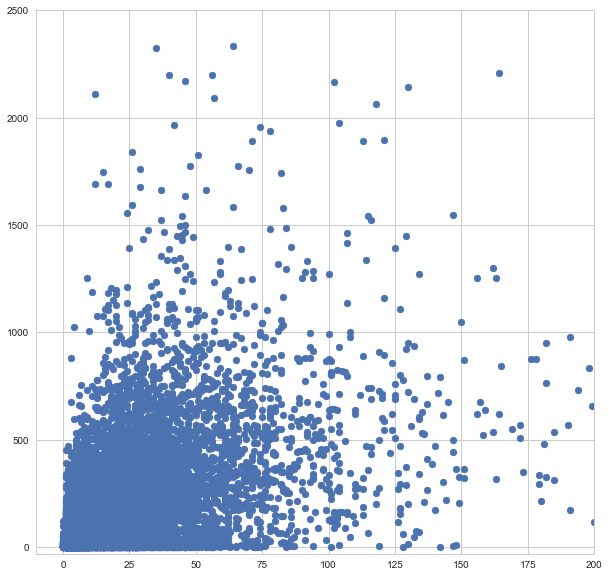

In [96]:
x = df_view['item_count']
y = df_view['view_count']
plt.figure(figsize=(10,10))
plt.scatter(x,y)
plt.xlim(-10,200)
plt.ylim(-30,2500)

plt.show()

# 오버샘플링

In [60]:
summary_table(X_train_scale)

,act,dtype,name,null,unique
0,2597810.0,float64,PRICE_RATE,0.0,71.0
1,2597810.0,float64,DISPPERIOD,0.0,18.0
2,2597810.0,float64,USABLE_DATE_MON,0.0,2.0
3,2597810.0,float64,USABLE_DATE_TUE,0.0,2.0
4,2597810.0,float64,USABLE_DATE_WED,0.0,2.0
5,2597810.0,float64,USABLE_DATE_THU,0.0,2.0
6,2597810.0,float64,USABLE_DATE_FRI,0.0,2.0
7,2597810.0,float64,USABLE_DATE_SAT,0.0,2.0
8,2597810.0,float64,USABLE_DATE_SUN,0.0,2.0
9,2597810.0,float64,USABLE_DATE_HOLIDAY,0.0,2.0


In [308]:
X_train.drop('proba_case',1, inplace=True)

In [309]:
X_train.columns

Index(['PREF_in', 'distance', 'proba_spot_pref', 'proba_GENRE_NAME',
       'PRICE_RATE', 'DISPPERIOD', 'VALIDPERIOD', 'USABLE_DATE_MON',
       'USABLE_DATE_TUE', 'USABLE_DATE_WED', 'USABLE_DATE_THU',
       'USABLE_DATE_FRI', 'USABLE_DATE_SAT', 'USABLE_DATE_SUN',
       'USABLE_DATE_HOLIDAY', 'USABLE_DATE_BEFORE_HOLIDAY', 'zprice', 'SEX_ID',
       'AGE', 'GENRE_NAME_Beauty', 'GENRE_NAME_Delivery service',
       'GENRE_NAME_Food', 'GENRE_NAME_Gift card', 'GENRE_NAME_Hair salon',
       'GENRE_NAME_Health and medical', 'GENRE_NAME_Hotel and Japanese hotel',
       'GENRE_NAME_Leisure', 'GENRE_NAME_Lesson',
       'GENRE_NAME_Nail and eye salon', 'GENRE_NAME_Other coupon',
       'GENRE_NAME_Relaxation', 'GENRE_NAME_Spa'],
      dtype='object')

In [256]:
X_train2

In [121]:
from imblearn.over_sampling import *

X1, y1 = SMOTE(random_state=0).fit_sample(X_train_scale,y_train)

In [122]:
X1 = pd.DataFrame(X1, columns=X_train_scale.columns)

In [123]:
X1.columns

Index(['PRICE_RATE', 'DISPPERIOD', 'USABLE_DATE_MON', 'USABLE_DATE_TUE',
       'USABLE_DATE_WED', 'USABLE_DATE_THU', 'USABLE_DATE_FRI',
       'USABLE_DATE_SAT', 'USABLE_DATE_SUN', 'USABLE_DATE_HOLIDAY',
       'USABLE_DATE_BEFORE_HOLIDAY', 'zprice', 'SEX_ID', 'AGE', 'VALID',
       'Case_BEAUTY', 'Case_CLASS', 'Case_DELIVERY', 'Case_EVENT', 'Case_FOOD',
       'Case_GIFT', 'Case_HAIR', 'Case_HEALTH', 'Case_HOTEL', 'Case_LEISURE',
       'Case_LESSON', 'Case_NAIL', 'Case_OTHER', 'Case_RELAXATION', 'Case_SPA',
       'Case_WEB'],
      dtype='object')

In [124]:
X1.shape

(4791116, 31)

In [157]:
len(X_train)

2597810

In [165]:
X.head()

,PREF_in,distance,proba_spot_pref,proba_case,PRICE_RATE,DISPPERIOD,VALIDPERIOD,USABLE_DATE_MON,USABLE_DATE_TUE,USABLE_DATE_WED,...,Case_HEALTH,Case_HOTEL,Case_LEISURE,Case_LESSON,Case_NAIL,Case_OTHER,Case_RELAXATION,Case_SPA,Case_WEB,VALID
0,0.0,237.740409,9.021525,8.573826,78.0,4.0,180.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3015.000000
1,0.0,237.740409,9.021525,8.573826,78.0,4.0,180.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3017.466667
2,0.0,237.740409,9.021525,8.573826,78.0,4.0,180.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3032.033333
3,0.0,237.740409,9.021525,8.573826,78.0,4.0,180.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3068.166667
4,0.0,237.740409,6.823667,8.573826,66.0,3.0,180.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1580.083333


In [184]:
X_train.head()

,PREF_in,distance,PRICE_RATE,DISPPERIOD,VALIDPERIOD,zprice,SEX_ID,AGE,usable_week,Case_BEAUTY,...,Case_HAIR,Case_HEALTH,Case_HOTEL,Case_LEISURE,Case_LESSON,Case_NAIL,Case_OTHER,Case_RELAXATION,Case_SPA,Case_WEB
0,0,237.740409,78.0,4.0,180.0,0.795357,0,25,9.0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,237.740409,78.0,4.0,180.0,0.795357,0,25,9.0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,237.740409,78.0,4.0,180.0,0.795357,0,25,9.0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,237.740409,78.0,4.0,180.0,0.795357,0,25,9.0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,237.740409,66.0,3.0,180.0,0.118216,0,25,9.0,0,...,0,0,0,0,0,0,0,0,0,0


In [183]:
X.columns, X_train.columns

(Index(['PREF_in', 'distance', 'PRICE_RATE', 'DISPPERIOD', 'VALIDPERIOD',
        'zprice', 'SEX_ID', 'AGE', 'usable_week', 'Case_BEAUTY', 'Case_CLASS',
        'Case_DELIVERY', 'Case_EVENT', 'Case_FOOD', 'Case_GIFT', 'Case_HAIR',
        'Case_HEALTH', 'Case_HOTEL', 'Case_LEISURE', 'Case_LESSON', 'Case_NAIL',
        'Case_OTHER', 'Case_RELAXATION', 'Case_SPA', 'Case_WEB'],
       dtype='object'),
 Index(['PREF_in', 'distance', 'PRICE_RATE', 'DISPPERIOD', 'VALIDPERIOD',
        'zprice', 'SEX_ID', 'AGE', 'usable_week', 'Case_BEAUTY', 'Case_CLASS',
        'Case_DELIVERY', 'Case_EVENT', 'Case_FOOD', 'Case_GIFT', 'Case_HAIR',
        'Case_HEALTH', 'Case_HOTEL', 'Case_LEISURE', 'Case_LESSON', 'Case_NAIL',
        'Case_OTHER', 'Case_RELAXATION', 'Case_SPA', 'Case_WEB'],
       dtype='object'))

# 언더 샘플링

In [ ]:
from imblearn.under_sampling import *
X2, y2 = NeighbourhoodCleaningRule(random_state=0).fit_sample(X_train,y_train)
X2 = pd.DataFrame(X2, columns=X_train.columns)

In [ ]:
from imblearn.combine import *
X2, y2 = SMOTETomek(random_state=0).fit_sample(X_train,y_train)
X2 = pd.DataFrame(X2, columns=X_train.columns)

In [40]:
proba = train.copy()

In [ ]:
train.isnu

In [41]:
proba.columns

Index(['PURCHASE_FLG', 'VIEW_DATE', 'PREF_in', 'distance', 'COUPON_ID_hash',
       'USER_ID_hash', 'VIEW', 'ITEM_COUNT', 'purchase_date', 'resid_small',
       'PURCHASEID_hash', 'CAPSULE_TEXT', 'GENRE_NAME', 'PRICE_RATE',
       'CATALOG_PRICE', 'DISCOUNT_PRICE', 'DISPFROM', 'DISPEND', 'DISPPERIOD',
       'VALIDFROM', 'VALIDEND', 'VALIDPERIOD', 'USABLE_DATE_MON',
       'USABLE_DATE_TUE', 'USABLE_DATE_WED', 'USABLE_DATE_THU',
       'USABLE_DATE_FRI', 'USABLE_DATE_SAT', 'USABLE_DATE_SUN',
       'USABLE_DATE_HOLIDAY', 'USABLE_DATE_BEFORE_HOLIDAY', 'spot_large',
       'spot_pref', 'spot_small', 'Case', 'Price', 'lnDPRICE', 'mDPRICE',
       'sDPRICE', 'zprice', 'SEX_ID', 'AGE', 'user_pref'],
      dtype='object')

In [62]:
ls = ['PURCHASE_FLG', 'GENRE_NAME', 'Case','spot_pref']
proba1 = proba.filter(ls)

In [49]:
result = pd.DataFrame(proba1.groupby('Case')['PURCHASE_FLG'].count())
result['구매수'] = proba1.groupby('Case')['PURCHASE_FLG'].sum()

In [51]:
result.rename(columns={'PURCHASE_FLG':'총개수'}, inplace=True)

In [53]:
result['proba_case'] = result['구매수'] / result['총개수'] * 100

In [54]:
result

,총개수,구매수,proba_case
Case,,,
BEAUTY,2073,176,8.490111
CLASS,631,44,6.973059
DELIVERY,739040,63364,8.573826
EVENT,678,43,6.342183
FOOD,685842,50311,7.335655
GIFT,77819,10852,13.945180
HAIR,51979,4396,8.457262
HEALTH,3169,309,9.750710
HOTEL,614910,20608,3.351385


In [55]:
result.to_csv('proba_case', encoding='utf-8')

In [57]:
result2 = pd.DataFrame(proba1.groupby('GENRE_NAME')['PURCHASE_FLG'].count())
result2['구매수'] = proba1.groupby('GENRE_NAME')['PURCHASE_FLG'].sum()

result2.rename(columns={'PURCHASE_FLG':'총개수'}, inplace=True)

result2['proba_GENRE_NAME'] = result2['구매수'] / result2['총개수'] * 100

In [59]:
result2

,총개수,구매수,proba_GENRE_NAME
GENRE_NAME,,,
Beauty,2073,176,8.490111
Delivery service,739040,63364,8.573826
Food,685842,50311,7.335655
Gift card,77819,10852,13.945180
Hair salon,51979,4396,8.457262
Health and medical,3169,309,9.750710
Hotel and Japanese hotel,614910,20608,3.351385
Leisure,90083,10198,11.320671
Lesson,28648,1672,5.836359


In [60]:
result2.to_csv('proba_genre', encoding='utf-8')

In [61]:
summary_table(proba)

,act,dtype,name,null,unique
0,2597810.0,int64,PURCHASE_FLG,0.0,2.0
1,2543993.0,datetime64[ns],VIEW_DATE,53817.0,2361323.0
2,2597810.0,int64,PREF_in,0.0,2.0
3,963076.0,float64,distance,1634734.0,263.0
4,2597810.0,object,COUPON_ID_hash,0.0,19452.0
5,2597810.0,object,USER_ID_hash,0.0,22833.0
6,2597810.0,float64,VIEW,0.0,2.0
7,202252.0,float64,ITEM_COUNT,2395558.0,33.0
8,202252.0,datetime64[ns],purchase_date,2395558.0,130310.0
9,202252.0,object,resid_small,2395558.0,56.0


In [63]:
result3 = pd.DataFrame(proba1.groupby('spot_pref')['PURCHASE_FLG'].count())
result3['구매수'] = proba1.groupby('spot_pref')['PURCHASE_FLG'].sum()

result3.rename(columns={'PURCHASE_FLG':'총개수'}, inplace=True)

result3['proba_spot_pref'] = result3['구매수'] / result3['총개수'] * 100

In [64]:
result3

,총개수,구매수,proba_spot_pref
spot_pref,,,
Aichi,80193,5913,7.373462
Aichi Prefecture,13,0,0.000000
Akita,6076,673,11.076366
Aomori,5888,465,7.897418
Chiba,56373,4789,8.495202
Chiba Prefecture,81,0,0.000000
Ehime,8640,660,7.638889
Fukui,7955,239,3.004400
Fukuoka,86129,7301,8.476820


In [66]:
result3.to_csv('proba_location', encoding='utf-8')

### visit proba

In [364]:
ls1 = ['PURCHASE_FLG', 'GENRE_NAME', 'Case','spot_pref','VIEW']
proba1 = proba.filter(ls1)

In [365]:
result4 = pd.DataFrame(proba1.groupby('GENRE_NAME')['VIEW'].count())
result4['구매수'] = proba1.groupby('GENRE_NAME')['VIEW'].sum()

result4.rename(columns={'VIEW':'총개수'}, inplace=True)

result4['visit_proba_GENRE_NAME'] = result4['구매수'] / result4['총개수'] * 100

result4.to_csv('visit_proba_genre', encoding='utf-8')

In [366]:
result5 = pd.DataFrame(proba1.groupby('Case')['VIEW'].count())
result5['구매수'] = proba1.groupby('Case')['VIEW'].sum()

result5.rename(columns={'VIEW':'총개수'}, inplace=True)

result5['visit_proba_case'] = result5['구매수'] / result5['총개수'] * 100

result5.to_csv('visit_proba_case', encoding='utf-8')

In [367]:
result6 = pd.DataFrame(proba1.groupby('spot_pref')['VIEW'].count())
result6['구매수'] = proba1.groupby('spot_pref')['VIEW'].sum()

result6.rename(columns={'VIEW':'총개수'}, inplace=True)

result6['visit_proba_spot_pref'] = result6['구매수'] / result6['총개수'] * 100

result6.to_csv('visit_proba_spot_pref', encoding='utf-8')